In [2]:
import sys
import os
import shap
import torch
import cv2
from torch.utils.data import DataLoader
from mri_dataset_chained import MRI_Dataset
from torchvision.models.efficientnet import efficientnet_v2_m
import numpy as np
import torchvision
from combined_classifier import CombinedClassifierL, CombinedClassifierLogReg 
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [3]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

val_dataset = MRI_Dataset('/Users/olath/Documents/GitHub/Master-thesis/Datasets/val-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', slice= [12, 72, 43, 6, 58, 43])

validation_loader  = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [4]:
axial = efficientnet_v2_m(num_classes = 3)
axial.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ AXIAL Magnitude_ 12 Ops_ 4 Dropout_ 0.4_202503070702_best.pth', weights_only=True, map_location=torch.device('mps')))
sagittal = efficientnet_v2_m(num_classes = 3)
sagittal.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ SAGITTAL Magnitude_ 16 Ops_ 4 Dropout_ 0.3_202503071355_best.pth', weights_only=True, map_location=torch.device('mps')))
coronal = efficientnet_v2_m(num_classes = 3)
coronal.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ CORONAL Magnitude_ 14 Ops_ 3 Dropout_ 0.4_202503070848_best.pth', weights_only=True, map_location=torch.device('mps')))
    

first_model = CombinedClassifierLogReg(3, axial, sagittal, coronal, dropout= 0.8, num_outputs = 1000)
first_model.load_state_dict(torch.load('/Users/olath/Downloads/model_3class logreg_202503071916_best.pth', weights_only=True, map_location=torch.device('mps')))
first_model.to(device)
first_model.eval()

CombinedClassifierLogReg(
  (axial_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              

In [5]:
axial = efficientnet_v2_m(num_classes = 2)
axial.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ AXIAL Magnitude_ 16 Ops_ 3 Dropout_ 0.2_202503120213_best.pth', weights_only=True, map_location=torch.device('mps')))
sagittal = efficientnet_v2_m(num_classes = 2)
sagittal.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ SAGITTAL Magnitude_ 16 Ops_ 2 Dropout_ 0.2_202503120244_best.pth', weights_only=True, map_location=torch.device('mps')))
coronal = efficientnet_v2_m(num_classes = 2)
coronal.load_state_dict(torch.load('/Users/olath/Downloads/model_Orientation_ CORONAL Magnitude_ 14 Ops_ 2 Dropout_ 0.2_202503120101_best.pth', weights_only=True, map_location=torch.device('mps')))
    

second_model = CombinedClassifierLogReg(2, axial, sagittal, coronal, dropout= 0.8, num_outputs = 1000)
second_model.load_state_dict(torch.load('/Users/olath/Downloads/model_2class logreg_202503131955_best.pth', weights_only=True, map_location=torch.device('mps')))
second_model.to(device)
second_model.eval()

CombinedClassifierLogReg(
  (axial_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              

In [6]:
def forward(X1, X2):
    first_output = first_model(X1)
    second_output = second_model(X2)

    return first_output, second_output


In [7]:
def evaluate(data_loader):
    
    first_outputs = torch.Tensor().to(device)
    second_outputs = torch.Tensor().to(device)
    true_labels = torch.Tensor().to(device)

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
        # for batch in data_loader:
            x1, x2, y = batch
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            first_output, second_output = forward(torch.Tensor.float(x1), torch.Tensor.float(x2))

            true_labels = torch.cat((true_labels,y),0)

            first_outputs = torch.cat((first_outputs, first_output),0)
            second_outputs = torch.cat((second_outputs, second_output),0)

    first_outputs = torch.sigmoid(first_outputs)
    second_outputs = torch.sigmoid(second_outputs)


    return true_labels, first_outputs, second_outputs

Evaluating: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


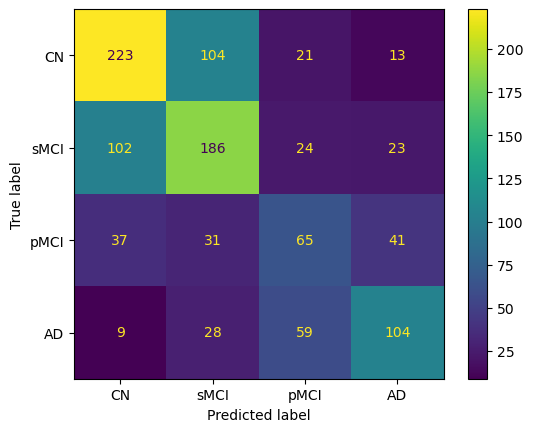

              precision    recall  f1-score   support

          CN       0.60      0.62      0.61       361
        sMCI       0.53      0.56      0.54       335
        pMCI       0.38      0.37      0.38       174
          AD       0.57      0.52      0.55       200

    accuracy                           0.54      1070
   macro avg       0.52      0.52      0.52      1070
weighted avg       0.54      0.54      0.54      1070



In [10]:
true_labels, first_outputs, second_outputs = evaluate(validation_loader)

final_pred_label = [None]*len(first_outputs)

first_outputs = torch.softmax(first_outputs, 1)

second_outputs = torch.softmax(second_outputs, 1)

threshold1 = 0.3497
threshold2 = 0.5100
threshold3 = 0.0200

for i in range(0, len(final_pred_label)):
    if first_outputs[i][1] > threshold1:
        
        if second_outputs[i][1] >= threshold2:
            final_pred_label[i] = 2
        else:
            final_pred_label[i] = 1

    else:
        
        if first_outputs[i][0] >= first_outputs[i][2] + threshold3:
            final_pred_label[i] = 0
        else:
            final_pred_label[i] = 3

conf_mat = confusion_matrix(true_labels.cpu(), final_pred_label, labels = [0,1,2,3])

display = ConfusionMatrixDisplay(conf_mat, display_labels= ['CN', 'sMCI', 'pMCI', 'AD'])

display.plot()

display_labels= ['CN', 'sMCI', 'pMCI', 'AD']

plt.xticks(range(len(display_labels)), display_labels)

plt.show()

print(classification_report(true_labels.cpu(), final_pred_label, labels = [0,1,2,3], target_names= ['CN', 'sMCI', 'pMCI', 'AD']))